<Figure size 1000x600 with 0 Axes>

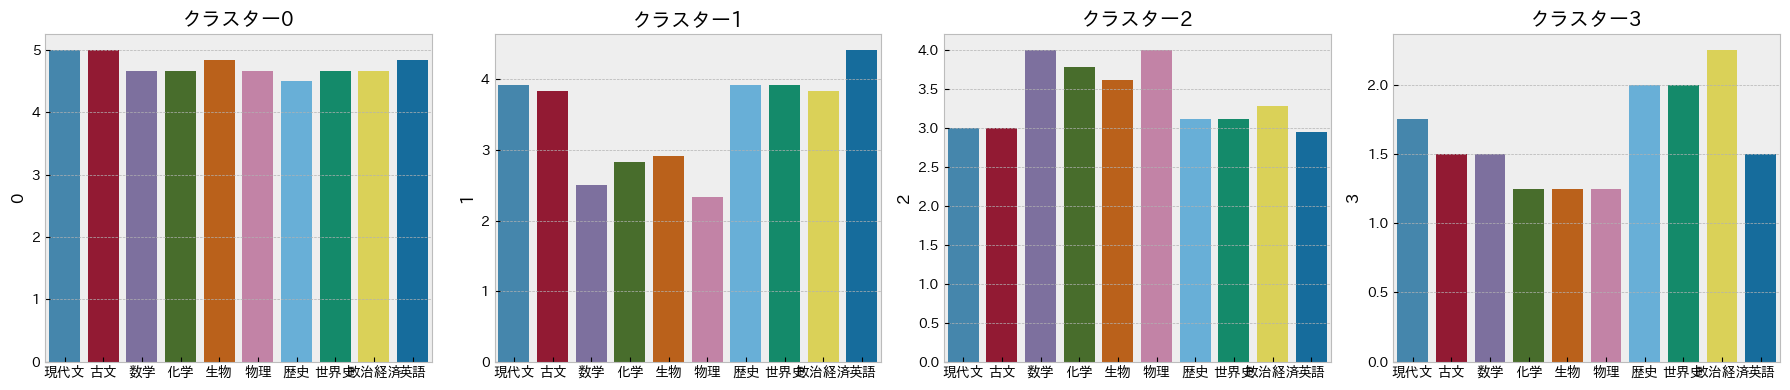

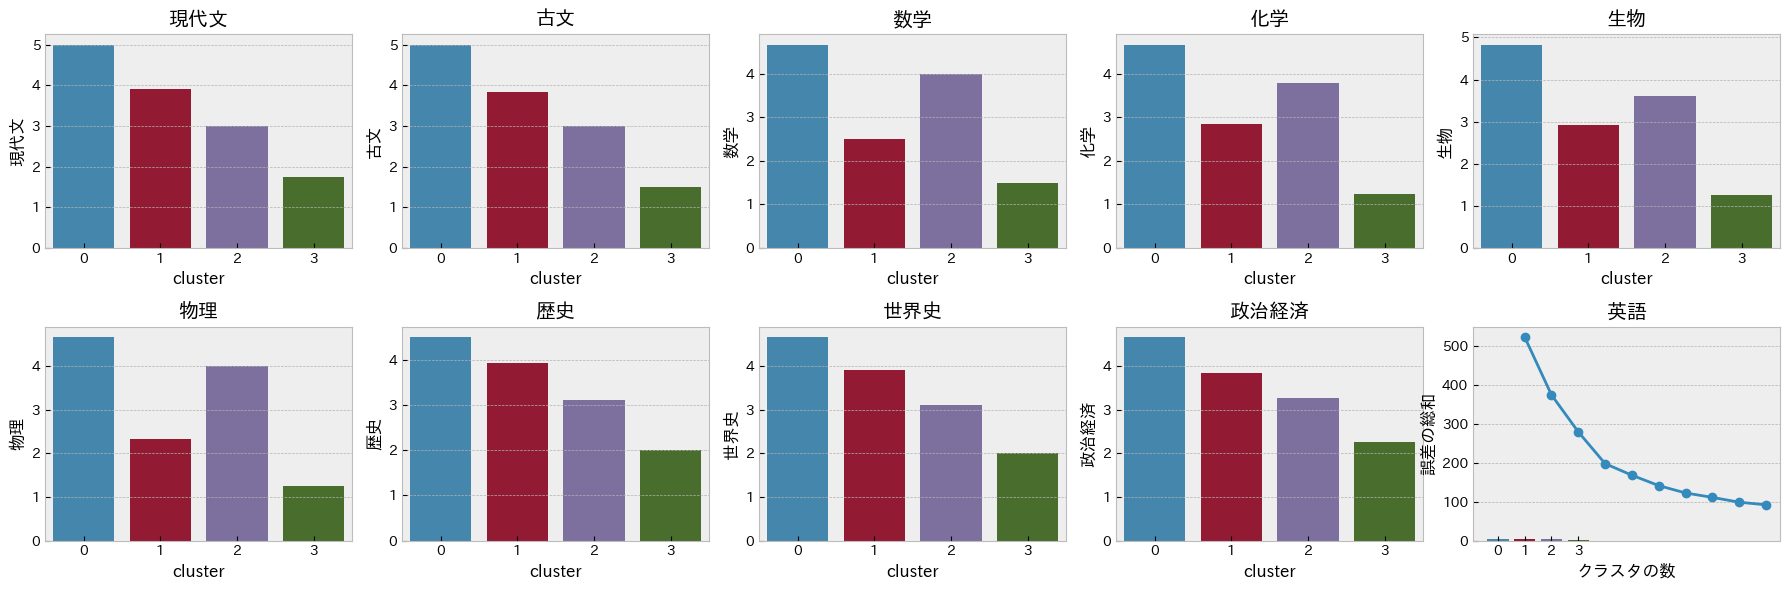

,現代文,古文,数学,化学,生物,物理,歴史,世界史,政治経済,英語,cluster
0,2,3,4,3,3,4,3,2,3,2,2
1,5,4,3,3,3,2,4,3,4,5,1
2,3,3,3,4,3,4,3,4,4,3,2
3,5,5,3,3,3,3,4,4,4,5,1
4,4,3,4,5,4,3,3,3,4,3,2
5,3,3,3,3,3,3,4,3,4,3,2
6,3,4,3,4,4,4,3,3,4,4,2
7,5,5,4,5,5,5,4,5,5,5,0
8,2,2,1,2,1,1,2,3,3,1,3
9,3,3,5,4,5,5,3,3,3,5,2


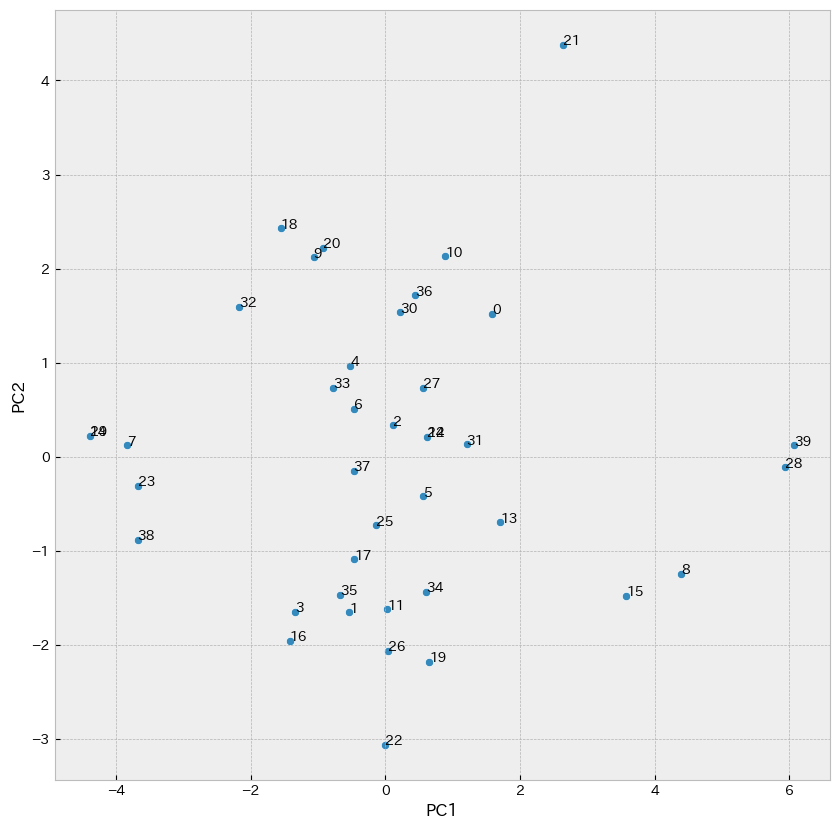

In [19]:
"""
多変量解析　クラスタリング（K-means法）
"""

"""
コードの流れメモ（主成分分析の）

1. とりあえず可視化して、データの性質を観察(このコードで見たのは、「ばらつき」と「相関」)
2. 主成分分析を実行（標準化→モデル作成→分析（累積寄与率（これを基に主成分の数を決定）→主成分ごとの関係性を可視化））
    ※主成分分析中に所々データをフォーマットする作業が入ってます（主にDataFrameにフォーマット 👈ただ見やすくするために）
3. 2で可視化して気づいたことをまとめる（これはコーディングと関係ないです。）

"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from scipy import stats
import warnings

import statsmodels.api as sm

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh') # matplotlib のスタイルの設定

plt.figure(figsize=(10, 6))

df = pd.read_csv('../../../data/dummy_data/academic_ability.csv')

# NOTE:　kmeansでは、np.array型のデータを扱うので、df.valuesでnp.array型に変換する
x = df.values

# クラスタリング
from sklearn.cluster import KMeans

# モデル作成
# NOTE: n_clusters は、クラスターの数を指定する
kmeans = KMeans(n_clusters=4, random_state=0)

# モデルの学習
kmeans.fit(x)

# 結果の確認
cluster = kmeans.labels_

# clusterカラムの追加
df['cluster'] = cluster

# クラスターごとにデータを分ける
groups = df.groupby('cluster')

# グループごとの数の確認
groups.size()

# 集計
groups.agg(['min', 'max', 'mean', 'median'])

# 一応、可視化
# NOTE:この場合の解釈例
# 　クラスタ０：　成績がすべて優秀なグループ
# 　クラスタ１：　文系のグループ
# 　クラスタ２：　理系のグループ
# 　クラスタ３：　成績がすべてあまりよくないグループ
# NOTE: 可視化後に、上記のグループごとに施策を考えていく
plt.figure(figsize=(18, 4))

num = kmeans.n_clusters

# クラスタごとに可視化
for n in range(num):
    plt.subplot(1, num, n+1)
    plt.title(f'クラスター{n}')
    sns.barplot(x = groups.mean().columns, y = groups.mean().iloc[n])
    plt.tight_layout()
    
# 科目ごとに可視化
plt.figure(figsize=(18, 6))

for n, col in enumerate(groups.mean().columns):
    plt.subplot(2, 5, n+1)
    plt.title(f'{col}')
    sns.barplot(x=groups.mean().index, y=groups.mean()[col])
    plt.tight_layout()
    
# 主成分分析とクラスタリング

# 適切な主成分の数を決定
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                n_init=10,
                random_state=0)
    km.fit(x)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('クラスタの数')
plt.ylabel('誤差の総和')
plt.show()

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# モデル作成
from sklearn.decomposition import PCA
model = PCA(n_components=2, random_state=0)

# 学習
# NOTE:この場合の解釈の例
#   PC1：　成績の優劣
# 　PC2：　文系と理系
feature = model.fit_transform(x_scaled)

# 新たにDataFrameを作成
new_df = df.copy()

# 主成分分析の結果を追加
new_df[['PC1', 'PC2']] = feature

plt.figure(figsize=(10, 10))

for x, y, name in zip(new_df['PC1'], new_df['PC2'], list(range(len(new_df)))):
    plt.text(x, y, name)

sns.scatterplot(x='PC1', y='PC2', data=new_df)


